This notebook produces visualizations of the model interpretable parameters (or parameter–derived quantities) in space and time.

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import equinox as eqx
import jax.numpy as jnp
from hydra_zen import instantiate, load_from_yaml
from IPython.display import HTML
from matplotlib import animation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import lambertw
import xarray as xr

from src.ec_mlp.data_driven_model import DataDrivenModel
from src.ec_mlp.drift_model import DriftModel
from src.ec_mlp.trainer_module import TrainerModule

In [2]:
ROOT = Path("../../..")
RUNS_DIR = ROOT / "euler_criterion/mlp/multirun/2026-02-08/09-28-33"
RUN_ID = "15"
DATA_DIR = ROOT / "data"

In [3]:
run_cfg = load_from_yaml(RUNS_DIR / RUN_ID / ".hydra" / "config.yaml")

In [4]:
trunk = instantiate(run_cfg.trunk)()
physical_head = instantiate(run_cfg.physical_head)()
mdn_head = instantiate(run_cfg.mdn_head)()

In [5]:
data_driven_model = DataDrivenModel(trunk, physical_head, mdn_head)
drift_model = DriftModel(
    data_driven_model=data_driven_model, 
    stress_normalization=1.0, 
    wind_normalization=1.0,
    delta_t=1.0 * 60.0 * 60.0  # 1 hour in seconds
)

In [6]:
drift_model = TrainerModule.load_from_checkpoint(
    RUNS_DIR / RUN_ID / "best_model.ckpt", drift_model=drift_model
).drift_model

/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:96: The state dict in PosixPath('../../../euler_criterion/mlp/multirun/2026-02-08/09-28-33/15/best_model.ckpt') contains no parameters.


In [7]:
lats = np.arange(-90, 91, 1)
lons = np.arange(-180, 181, 1)
grid_lat, grid_lon = np.meshgrid(lats, lons, indexing="ij")

months = np.arange(1, 13)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

inputs_3d = np.zeros((len(months), len(lats), len(lons), 3))
inputs_3d[..., 0] = np.repeat(months[:, np.newaxis, np.newaxis], len(lats), axis=1).repeat(len(lons), axis=2)
inputs_3d[..., 1] = np.repeat(grid_lat[np.newaxis, ..., :], len(months), axis=0)
inputs_3d[..., 2] = np.repeat(grid_lon[np.newaxis, ..., :], len(months), axis=0)
inputs_1d = inputs_3d.reshape(-1, 3)

physical_parameters, mdn_parameters = eqx.filter_vmap(
    lambda arr: drift_model.get_physical_and_mdn_parameters(
        arr[0], arr[1], arr[2], to_physical_space=True, in_degrees=True
    )
)(jnp.asarray(inputs_1d))

In [8]:
beta_e, theta_e, beta_w = physical_parameters
pi_k, mu_k, sigma_k, rho_k = mdn_parameters

In [9]:
u_eps_mean, v_eps_mean = eqx.filter_vmap(drift_model.get_mean_residual_velocity_from_mdn_parameters)(pi_k, mu_k)
dx_eps_mean = u_eps_mean * drift_model.delta_t
dy_eps_mean = v_eps_mean * drift_model.delta_t

u_eps_mode, v_eps_mode = eqx.filter_vmap(drift_model.get_mode_residual_velocity_from_mdn_parameters)(pi_k, mu_k)
dx_eps_mode = u_eps_mode * drift_model.delta_t
dy_eps_mode = v_eps_mode * drift_model.delta_t

K_crossflow = eqx.filter_vmap(drift_model.get_crossflow_diffusivity_from_mdn_parameters)(
    pi_k, mu_k, sigma_k, rho_k
)

def get_alongflow_diffusivity(pi_k, mu_k, sigma_k, rho_k):
    K_tensor = drift_model.get_diffusivity_tensor_from_mdn_parameters(pi_k, mu_k, sigma_k, rho_k)
    eigvals = jnp.linalg.eigvalsh(K_tensor)
    K_alongflow = eigvals[1]
    return K_alongflow

K_alongflow = eqx.filter_vmap(get_alongflow_diffusivity)(pi_k, mu_k, sigma_k, rho_k)

In [10]:
beta_e_map = beta_e.reshape(len(months), len(lats), len(lons))
theta_e_map = theta_e.reshape(len(months), len(lats), len(lons))
beta_w_map = beta_w.reshape(len(months), len(lats), len(lons))
u_eps_mean_map = u_eps_mean.reshape(len(months), len(lats), len(lons))
v_eps_mean_map = v_eps_mean.reshape(len(months), len(lats), len(lons))
u_eps_mode_map = u_eps_mode.reshape(len(months), len(lats), len(lons))
v_eps_mode_map = v_eps_mode.reshape(len(months), len(lats), len(lons))
dx_eps_mean_map = dx_eps_mean.reshape(len(months), len(lats), len(lons))
dy_eps_mean_map = dy_eps_mean.reshape(len(months), len(lats), len(lons))
dx_eps_mode_map = dx_eps_mode.reshape(len(months), len(lats), len(lons))
dy_eps_mode_map = dy_eps_mode.reshape(len(months), len(lats), len(lons))
K_crossflow_map = K_crossflow.reshape(len(months), len(lats), len(lons))
K_alongflow_map = K_alongflow.reshape(len(months), len(lats), len(lons))

In [11]:
# grid = xr.Dataset(
#     {
#         "month": (["month"], months),
#         "latitude": (["latitude"], lats),
#         "longitude": (["longitude"], lons)
#     }
# )

# xr.open_mfdataset(
#     "../../../data/density/*.nc",
#     drop_variables=[
#         "Density_L2", "Density_L1", "Density_relerr", "climatology_bounds", "obsid", "obsDensity",
#         "obslon", "obslat", "obstime", "obsdepth"
#     ]
# ).interp(
#     depth=0, kwargs={"fill_value": "extrapolate"}
# ).drop_vars(
#     "depth"
# ).rename(
#     {"Density": "density", "lat": "latitude", "lon": "longitude", "time": "month"}
# ).assign_coords(
#     month=months
# ).interp_like(
#     grid
# ).chunk(
#     -1
# ).to_zarr(
#     DATA_DIR / "density_climatology.zarr", mode="w"
# )

In [12]:
density_ds = xr.open_zarr(DATA_DIR / "density_climatology.zarr")
f = 2 * 7.2921e-5 * np.sin(np.radians(density_ds.latitude))  # Coriolis parameter

def invert_ekman_layer_depth(beta_e, f, rho):
    """
    Folowing Ekman theory and the empirical Ekman model definition:
    $$
    \beta_e = \frac{\sqrt{2}}{\rho f D_e} e^{\frac{z}{D_e}}
    $$
    using the Lambert W function, we can solve for the Ekman layer depth $D_e$, 
    given $\beta_e$, the Coriolis parameter $f$, and the reference density $\rho$:
    $$
    D_e = \frac{z}{W \left( \beta_e z \frac{\rho f}{\sqrt{2}} \right)}
    """
    z = -15  # reference depth in meters
    W_arg = beta_e * z * rho * np.abs(f) / np.sqrt(2)
    lw = xr.where(W_arg > -1 / np.e, lambertw(W_arg, k=0), lambertw(W_arg, k=-1))
    D_e = z / np.real(lw)
    return D_e

ekman_layer_depth_map = invert_ekman_layer_depth(np.asarray(beta_e_map), f, density_ds.density)

ekman_layer_depth_map.attrs["long_name"] = "Ekman layer depth implied by $\\beta_e$"
ekman_layer_depth_map.attrs["units"] = "m"

In [13]:
mask_ds = xr.open_zarr(DATA_DIR / "sea_land_mask.zarr")
mask = mask_ds["is_sea"]
mask_int = mask.astype(int)
mask_coarse = mask_int.coarsen(latitude=4, longitude=4, boundary="trim").mean()
mask_1deg = (mask_coarse.interp(latitude=lats, longitude=lons, method="nearest") > 0.5).values

In [14]:
def to_da(arr):
    da = xr.DataArray(
        arr,
        coords={
            "month": months,
            "latitude": lats,
            "longitude": lons
        },
        dims=["month", "latitude", "longitude"],
    )
    da = da.where(mask_1deg)
    return da


def plot_field(da, cmap, vmin, vmax, label, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})

    im = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.025,
            "fraction": 0.05,
            "label": label,
        },
    )

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color="lightgrey")

    fig.tight_layout()

    return fig, ax, im


def plot_annual_movie(da, cmap, vmin, vmax, label):
    fig, ax, im = plot_field(da.isel(month=0), cmap, vmin, vmax, label)
    title = ax.set_title(month_names[0])

    def update(frame):
        im.set_array(da.isel(month=frame).values.ravel())
        title.set_text(month_names[frame])
        return im, title

    anim = animation.FuncAnimation(fig, update, frames=len(months), interval=400, blit=True, repeat=True)

    return HTML(anim.to_html5_video())


def plot_annual_mean_field(da, cmap, vmin, vmax, label):
    fig, ax, _ = plot_field(da.mean(dim="month"), cmap, vmin, vmax, label)
    ax.set_title("Annual mean")
    return fig, ax


def plot_spatial_mean(da, label, take_abs=False):
    da = da.where(np.isfinite(da))

    da_north = da.sel(latitude=slice(0, 90))
    da_south = da.sel(latitude=slice(-90, 0))

    if take_abs:
        da_north = np.abs(da_north)

    fig, ax = plt.subplots()
    da_north.weighted(np.cos(np.deg2rad(da_north.latitude))).mean(
        dim=["latitude", "longitude"]
    ).plot(ax=ax, label=f"Northern Hemisphere", linestyle="-", marker="o")

    da_south.weighted(np.cos(np.deg2rad(da_south.latitude))).mean(
        dim=["latitude", "longitude"]
    ).plot(ax=ax, label=f"Southern Hemisphere", linestyle="--", marker="x")

    ax.legend()
    ax.set_title("Spatial mean")
    
    ax.set_xticks(months)
    ax.set_xticklabels(month_names)
    ax.set_xlabel("Month")
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)

    fig.tight_layout()

    return fig, ax

In [15]:
def extended_center_cmap(base_cmap, vmin, vcenter_low, vcenter_high, vmax, n=256):
    lower = (vcenter_low - vmin) / (vmax - vmin)
    upper = (vcenter_high - vmin) / (vmax - vmin)

    colors_low  = base_cmap(np.linspace(0.0, 0.5, int(n * lower)))
    colors_mid  = np.ones((int(n * (upper - lower)), 4))
    colors_high = base_cmap(np.linspace(0.5, 1.0, n - len(colors_low) - len(colors_mid)))

    colors = np.vstack((colors_low, colors_mid, colors_high))
    return ListedColormap(colors)

### $\beta_e$

In [16]:
da = to_da(beta_e_map)

vmax = da.max()
label = "$\\beta_e$ parameter of the Ekman term (m$^2$ s kg$^{-1}$)"

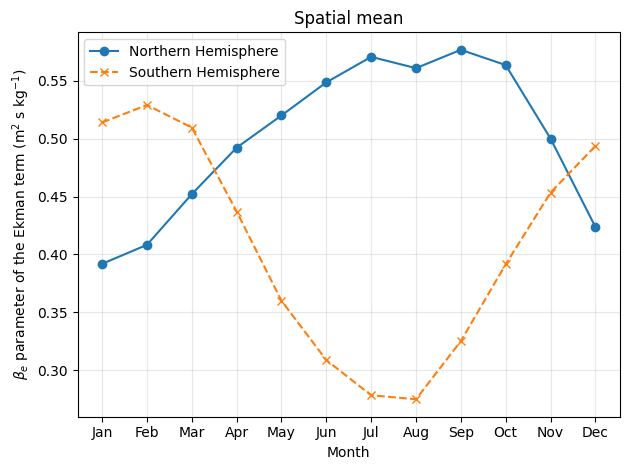

In [17]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

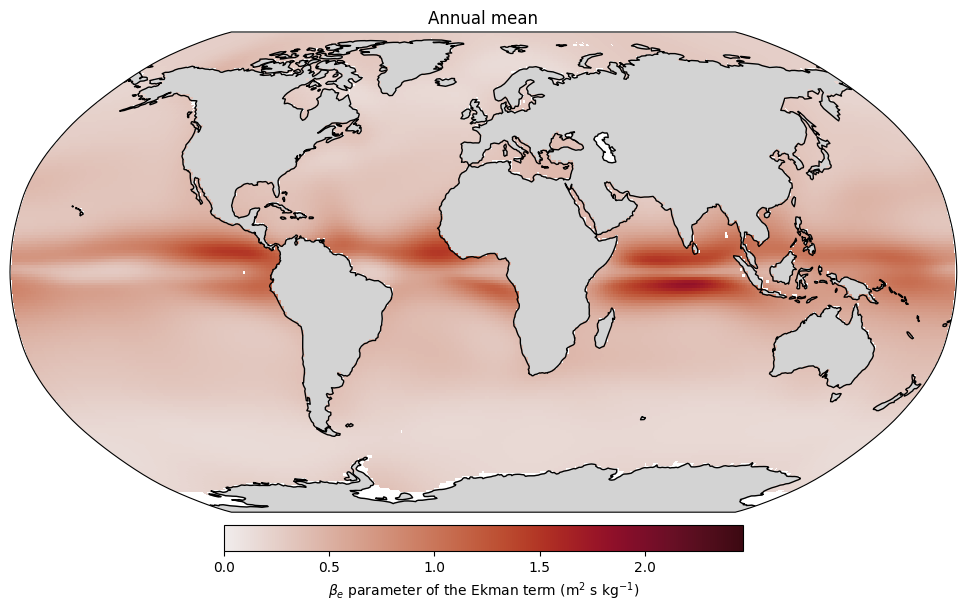

In [60]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [63]:

plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label)

### $\theta_e$

In [18]:
da = to_da(theta_e_map)

vmax = np.abs(da).max()
vcenter = 45

theta_e_cmap = extended_center_cmap(
    base_cmap=cmo.balance, vmin=-vmax, vcenter_low=-vcenter, vcenter_high=vcenter, vmax=vmax
)

label = "$\\theta_e$ parameter of the Ekman term (°)"

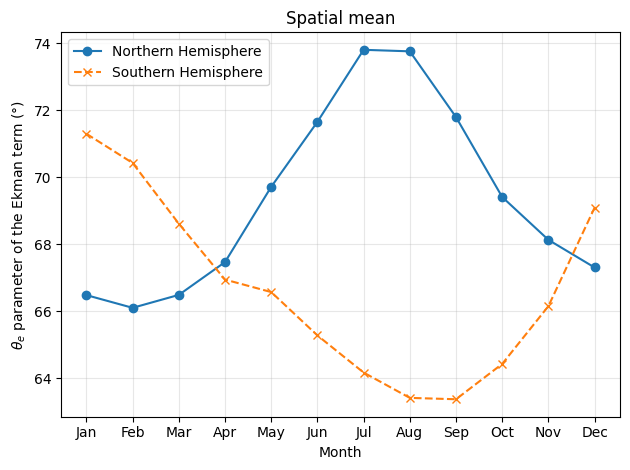

In [19]:
fig, ax = plot_spatial_mean(da, label, take_abs=True)
plt.show()

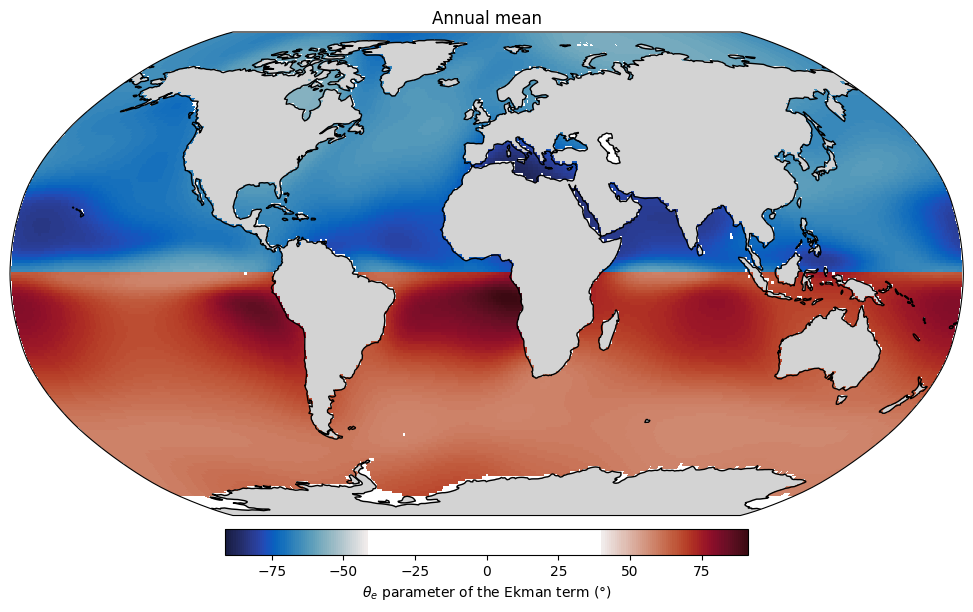

In [73]:
fig, ax = plot_annual_mean_field(da, theta_e_cmap, None, None, label)
plt.show()

In [74]:

plt.ioff()
plot_annual_movie(da, theta_e_cmap, None, None, label)

### $D_E$

In [20]:
da = ekman_layer_depth_map

label = "Ekman layer depth implied by $\\beta_e$ (m)"

/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


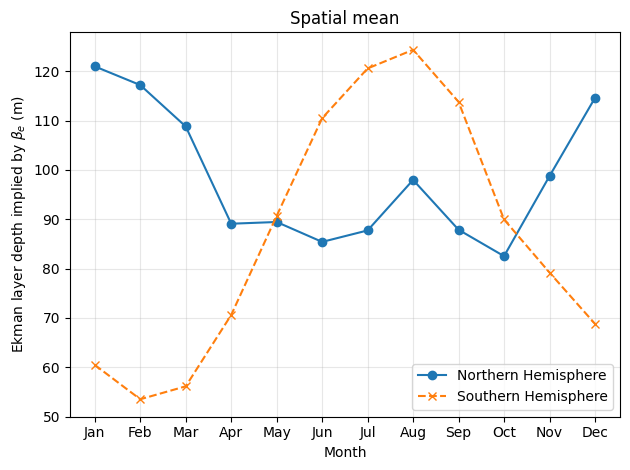

In [21]:
fig, ax = plot_spatial_mean(da, label, take_abs=True)
plt.show()

/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


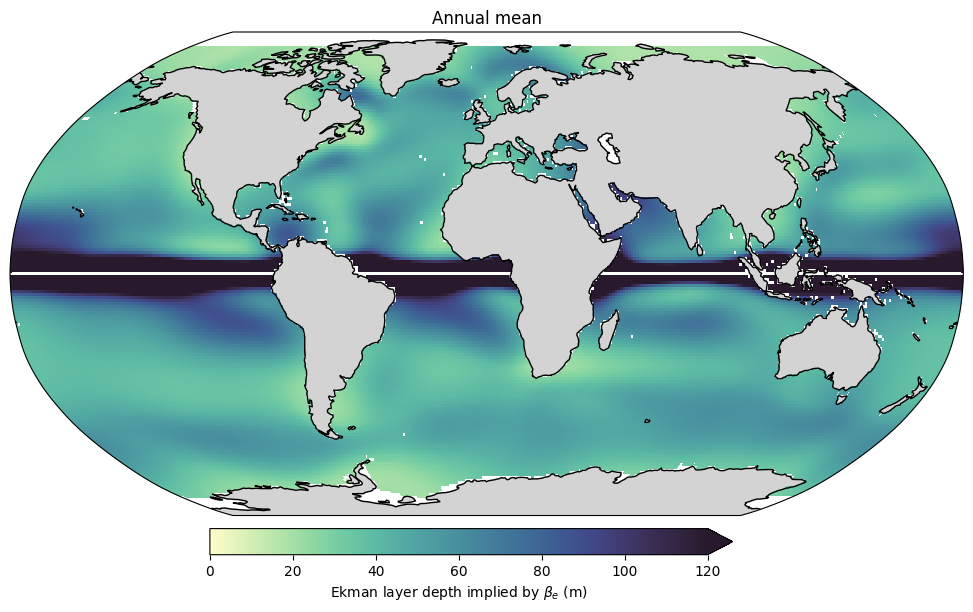

In [148]:
fig, ax = plot_annual_mean_field(da, cmo.deep, 0, 120, label)
plt.show()

In [149]:

plt.ioff()
plot_annual_movie(da, cmo.deep, 0, 120, label)

/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekman-mdn-calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/bertrava/miniforge3/envs/ekm

### $\beta_w$

In [22]:
da = to_da(beta_w_map)

vmax = da.max()
label = "$\\beta_w$ parameter of the Leeway term (%)"

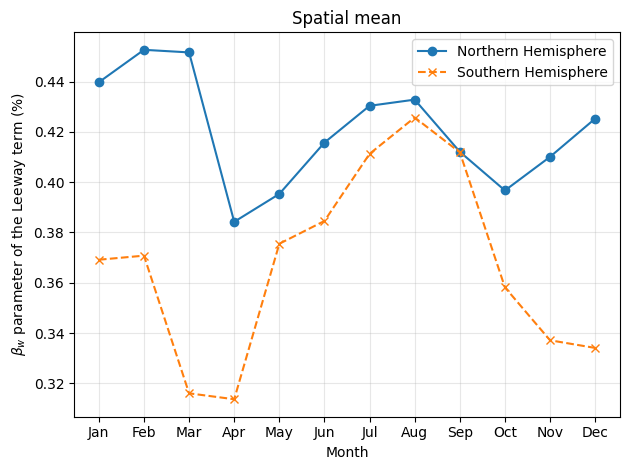

In [23]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

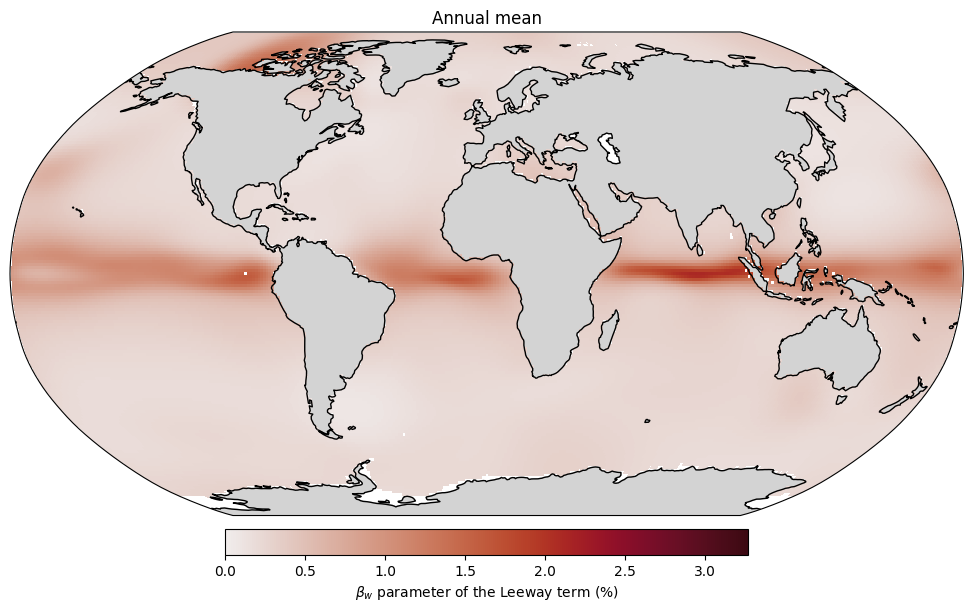

In [86]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [ ]:
plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label)

### $\epsilon_u$

#### mean

In [24]:
da = to_da(u_eps_mean_map)

vmax = 0.25
label = "Zonal residual mean (m s$^{-1}$)"

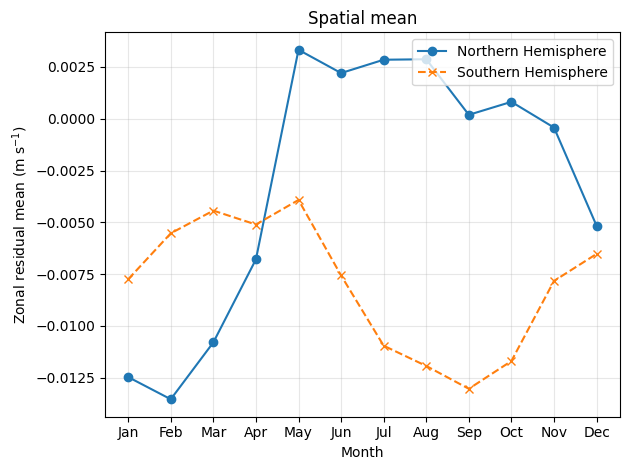

In [25]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

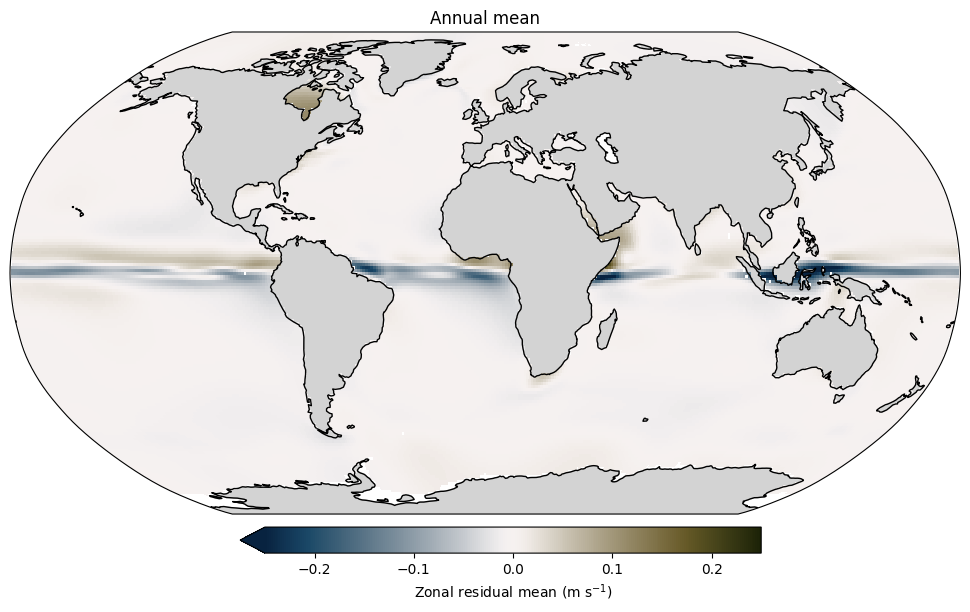

In [91]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [92]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label)

#### mode

In [26]:
da = to_da(u_eps_mode_map)

vmax = 0.25
label = "Zonal residual mode (m s$^{-1}$)"

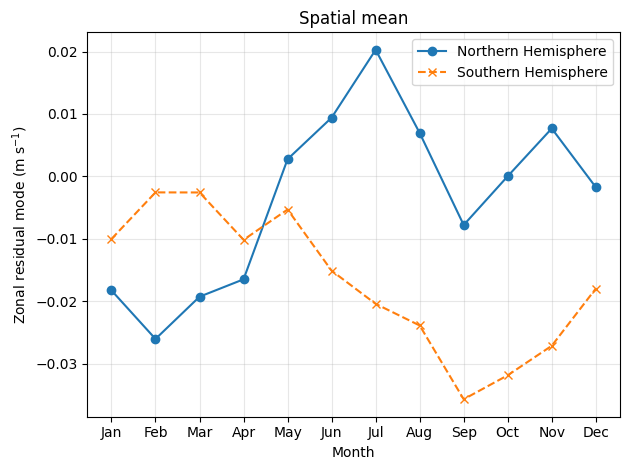

In [27]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

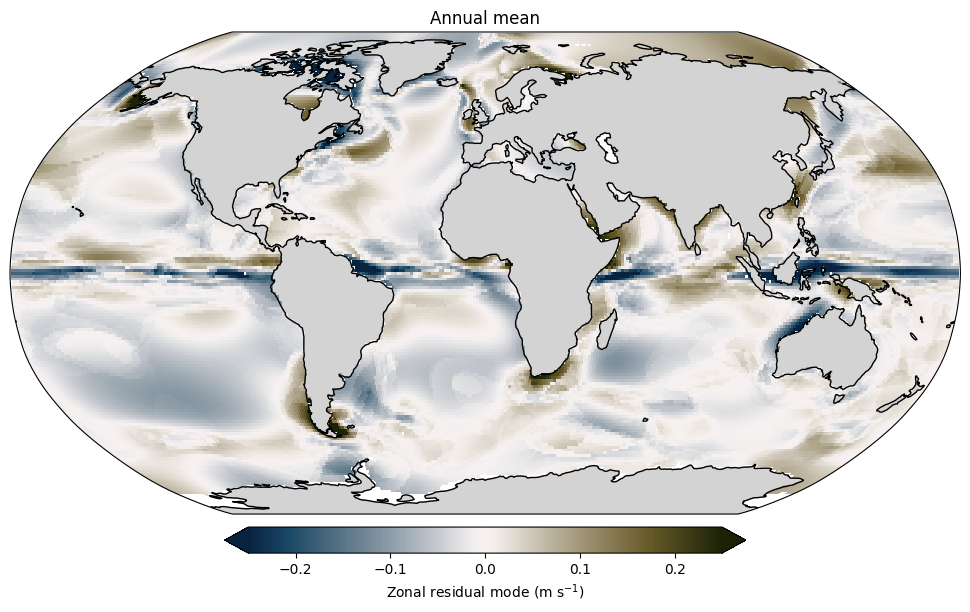

In [101]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [102]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label)

### $\epsilon_v$

#### mean

In [28]:
da = to_da(v_eps_mean_map)

vmax = 0.25
label = "Meridional residual mean (m s$^{-1}$)"

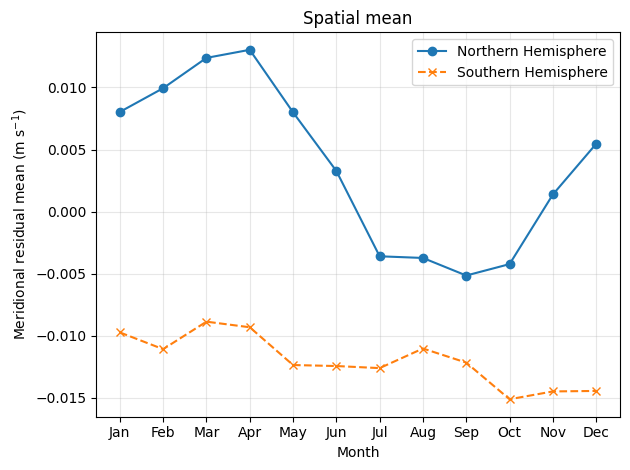

In [29]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

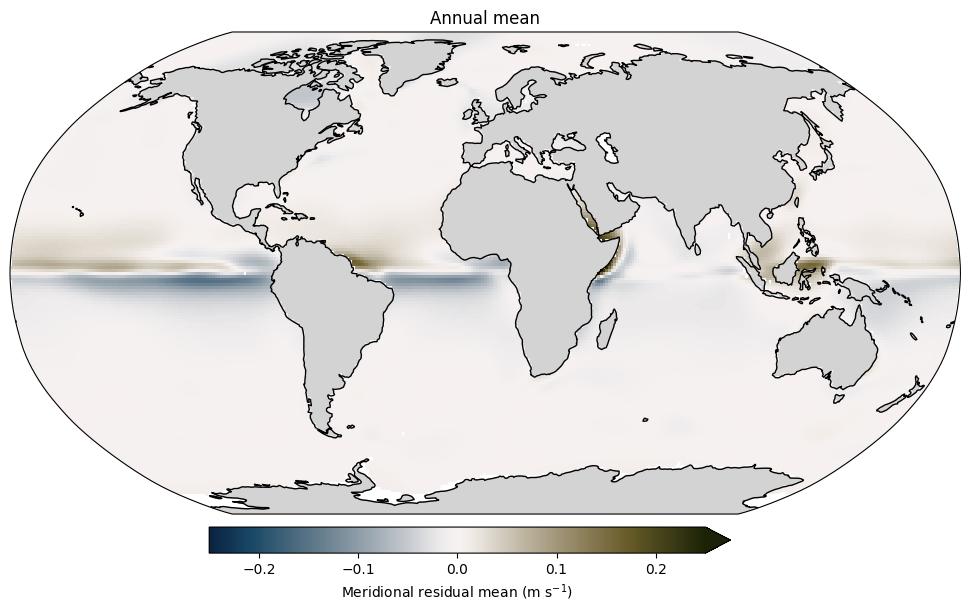

In [96]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [97]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label)

#### mode

In [30]:
da = to_da(v_eps_mode_map)

vmax = 0.25
label = "Meridional residual mode (m s$^{-1}$)"

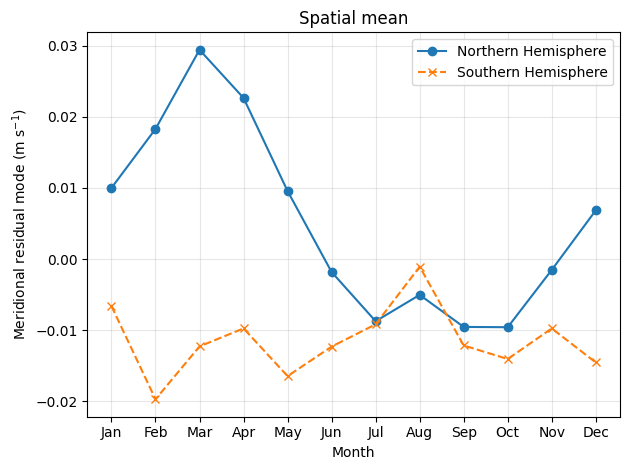

In [31]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

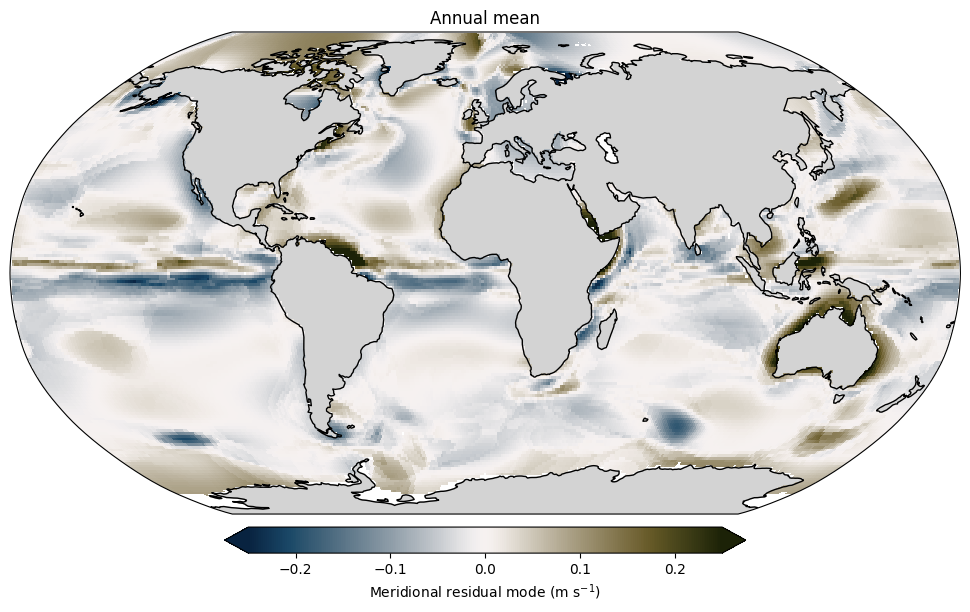

In [106]:
fig, ax = plot_annual_mean_field(da, cmo.diff, -vmax, vmax, label)
plt.show()

In [107]:

plt.ioff()
plot_annual_movie(da, cmo.diff, -vmax, vmax, label)

### Cross-flow lateral diffusivity

In [32]:
da = to_da(K_crossflow_map)

vmax = da.max()
label = "Cross-flow lateral diffusivity (m$^2$ s$^{-1}$)"

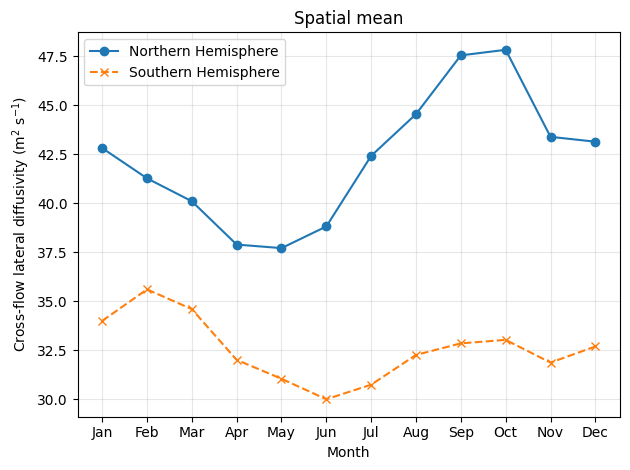

In [33]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

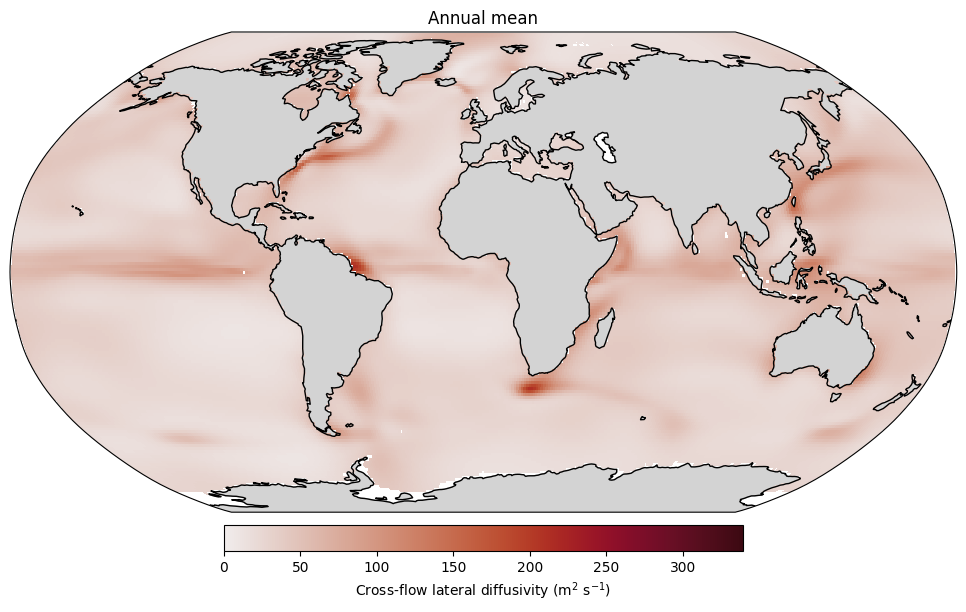

In [111]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [112]:
plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label)

### Along-flow lateral diffusivity

In [34]:
da = to_da(K_alongflow_map)

label = "Along-flow lateral diffusivity (m$^2$ s$^{-1}$)"

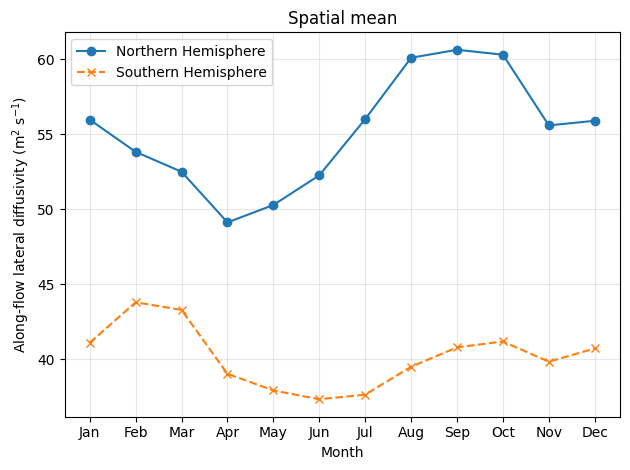

In [35]:
fig, ax = plot_spatial_mean(da, label)
plt.show()

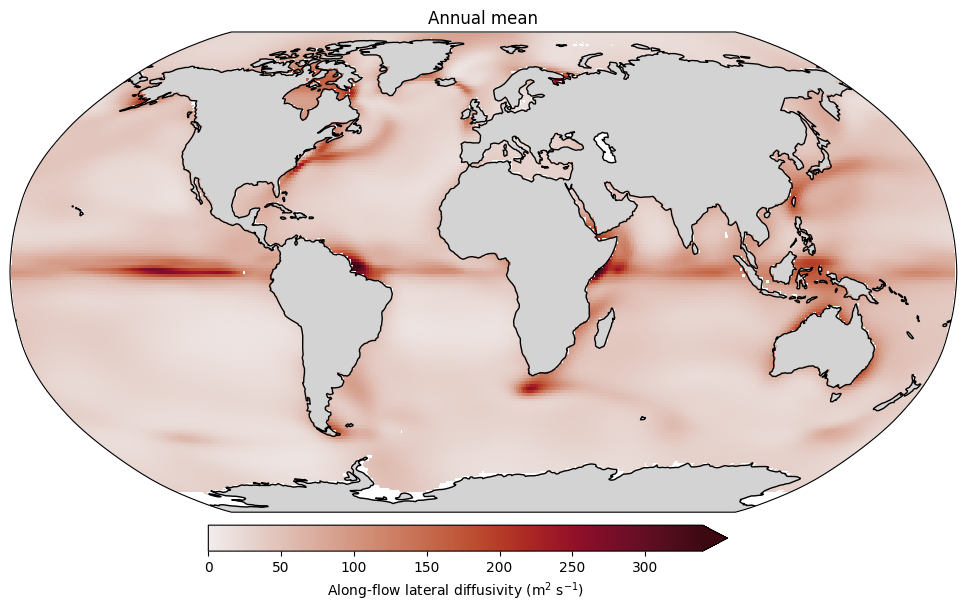

In [121]:
fig, ax = plot_annual_mean_field(da, cmo.amp, 0, vmax, label)
plt.show()

In [122]:
plt.ioff()
plot_annual_movie(da, cmo.amp, 0, vmax, label)